Partner-1: Siddhesh Sreedar (sidsr770)

Partner-2: Hugo Morvan (hugmo418)


# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Class LiU/Semester 2 - Part 2/Deep Learning/Labs/Laboration1_DNN/data"

/content/drive/MyDrive/Class LiU/Semester 2 - Part 2/Deep Learning/Labs/Laboration1_DNN/data


# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [ ]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";

# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

Question 2: How much memory does the graphics card have?

Question 3: What is stored in the GPU memory while training a DNN ?

> Question 1: The Nvidia RTX 3090 has 10496 cuda cores.

> Question 2: The graphics card has 24 GB of RAM.

> Question 3: The input data, the weights and the model are stored in the GPU memory while training a DNN.

# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [ ]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')


# Remove the first 24 covariates (columns)
X = X[:,24:]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
print("The number of example is", Y.shape[0])


The covariates have size (764137, 92).
The labels have size (764137,).
The number of example is 764137


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


> Question 4: Given the data imbalance, a naive classifier could obtain an accuray of 0.8408 by always chossing class 1.

In [ ]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()

# Print the number of NaNs (not a number) in the labels
print("The number of NaNs in the labels is", sum(np.isnan(Y)))

# Print the number of NaNs in the covariates
print("The number of NaNs in the covariates is", sum(sum(np.isnan(X))))

classes_count = np.unique(Y, return_counts = True)
print(f"A naive classifier can obtain an accuracy of {classes_count[1][1]/(classes_count[1][1]+classes_count[1][0]):.4f}")

The number of NaNs in the labels is 0
The number of NaNs in the covariates is 0
A naive classifier can obtain an accuracy of 0.8408


# Part 6: Preprocessing

Lets do some simple preprocessing

In [ ]:
# Convert covariates to floats
Xcopy = X.astype(float)

# Convert labels to integers
Ycopy = Y.astype(int)

# Remove mean of each covariate (column)
Xcopy -= Xcopy.mean(axis = 0)

# Divide each covariate (column) by its standard deviation
Xcopy /= Xcopy.std(axis = 0)

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print("Mean of X:", Xcopy.mean(axis = 0))
print("Std of X:", Xcopy.std(axis = 0))

Mean of X: [-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-13 -6.34816648e-13
 -1.62109649e-

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [ ]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(Xcopy, Ycopy, test_size=0.3, random_state=123)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
train_labels_count = np.unique(Ytrain, return_counts = True)
print("In the training set, the number of class 0 examples is", train_labels_count[1][0],
      "and the number of class 1 examples is" , train_labels_count[1][1])
temp_labels_count = np.unique(Ytemp, return_counts = True)
print("In the remaining set, the number of class 0 examples is", temp_labels_count[1][0],
      "and the number of class 1 examples is" , temp_labels_count[1][1])


Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
In the training set, the number of class 0 examples is 85249 and the number of class 1 examples is 449646
In the remaining set, the number of class 0 examples is 36372 and the number of class 1 examples is 192870


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [ ]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.5, random_state=123)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.losses import BinaryCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01,
              use_bn=False, use_dropout=False, use_custom_dropout=False):

    # Setup optimizer, depending on input parameter string
    if optimizer == "sgd":
        optm = SGD(learning_rate=learning_rate)
    elif optimizer == "adam":
        optm = Adam(learning_rate=learning_rate)

    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function

    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation = act_fun, input_dim = input_shape))
    if use_dropout:
        model.add(Dropout(rate=0.5))
    if use_bn:
        model.add(BatchNormalization())
    if use_custom_dropout:
        model.add(myDropout(0.5))

    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation = act_fun))
        if use_dropout:
            model.add(Dropout(rate=0.5))
        if use_bn:
            model.add(BatchNormalization())
        if use_custom_dropout:
            model.add(myDropout(0.5))


    # Add final layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss = BinaryCrossentropy(), metrics=["accuracy"], optimizer = optm)

    return model

In [ ]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):

    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = Xtrain.shape[1]

# Build the model
model1 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size)

Epoch 1/20
54/54 [==============================] - 3s 11ms/step - loss: 0.4426 - accuracy: 0.8281 - val_loss: 0.3980 - val_accuracy: 0.8416
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.3783 - accuracy: 0.8406 - val_loss: 0.3520 - val_accuracy: 0.8416
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 0.3274 - accuracy: 0.8406 - val_loss: 0.2977 - val_accuracy: 0.8416
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2758 - accuracy: 0.8406 - val_loss: 0.2519 - val_accuracy: 0.8416
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2388 - accuracy: 0.8513 - val_loss: 0.2238 - val_accuracy: 0.8622
Epoch 6/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2177 - accuracy: 0.8777 - val_loss: 0.2086 - val_accuracy: 0.8924
Epoch 7/20
54/54 [==============================] - 1s 10ms/step - loss: 0.2063 - accuracy: 0.8932 - val_loss: 0.2000 - val_accuracy: 0.8985
Epoch 8/20
54/54 [

In [ ]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 6ms/step - loss: 0.1742 - accuracy: 0.9093
Test loss: 0.1742
Test accuracy: 0.9093


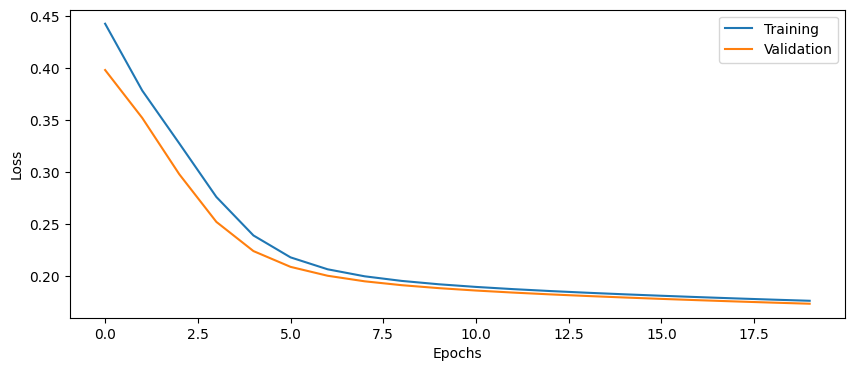

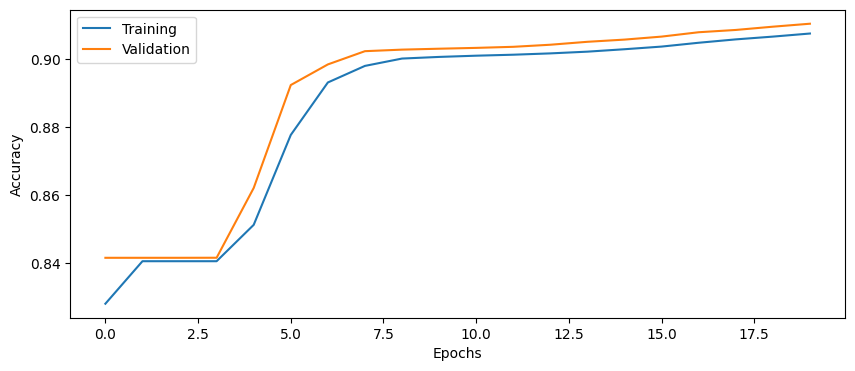

In [ ]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

> If we add several dense layers without specifying the activation function then it is the same as having a single layer since there is no nonlinear transformation happening.

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?

> The weights in a neural network were often initialized using random numbers from standard gaussian (mean 0, variance 1)


# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights_calc = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(Ytrain), y = Ytrain)

# Print the class weights
print("Class weights:", class_weights_calc)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights,
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights_calc[0], 1: class_weights_calc[1]}


Class weights: [3.13725088 0.59479568]


### 2 layers, 20 nodes, class weights

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model2 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

history2 = model2.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 11ms/step - loss: 0.6866 - accuracy: 0.8620 - val_loss: 0.6281 - val_accuracy: 0.8817
Epoch 2/20
54/54 [==============================] - 0s 7ms/step - loss: 0.5402 - accuracy: 0.8801 - val_loss: 0.4681 - val_accuracy: 0.8814
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 0.3756 - accuracy: 0.8798 - val_loss: 0.3386 - val_accuracy: 0.8814
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2801 - accuracy: 0.8798 - val_loss: 0.2909 - val_accuracy: 0.8817
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2431 - accuracy: 0.8802 - val_loss: 0.2733 - val_accuracy: 0.8824
Epoch 6/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2272 - accuracy: 0.8816 - val_loss: 0.2649 - val_accuracy: 0.8846
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2187 - accuracy: 0.8844 - val_loss: 0.2586 - val_accuracy: 0.8877
Epoch 8/20
54/54 [=

In [ ]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 4ms/step - loss: 0.2328 - accuracy: 0.9016
Test loss: 0.2328
Test accuracy: 0.9016


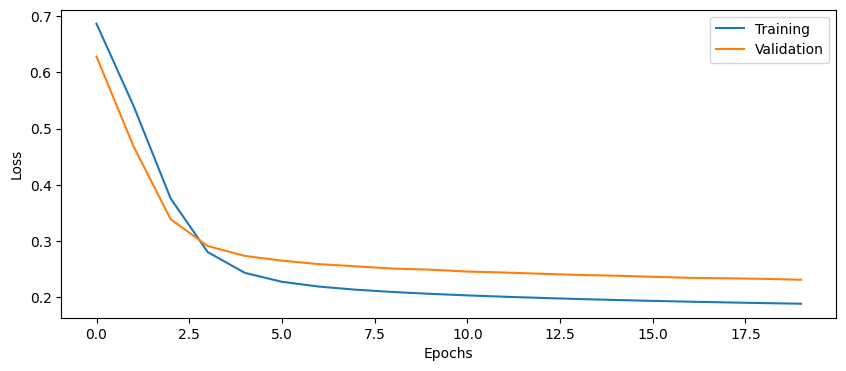

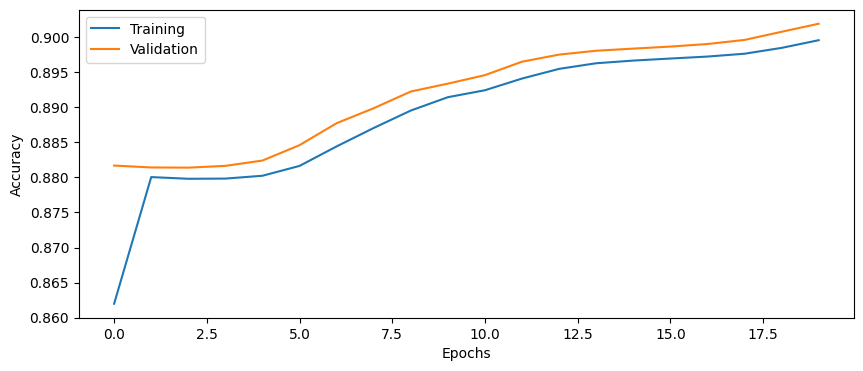

In [ ]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results.

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

Question 11: What limits how large the batch size can be?

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

Question-7: Batch size bascially is the number of samples used per gradient update. So using a particular amount instead of the entire data at once helps to find the minima better as it uses different samples in each gradient update.

Question-10: The amount of training data: 534895.

For batch size 100: 5348.95 times the weights are updated.
For batch size 1,000: 534.895 times the weights are updated.
For batch size 10,000: 53.4895 times the weights are updated.

As we increase the batch size, the training happens faster.

Question-11: The batch size is related to the amount of times the weights is updated in each epoch. So if we increase the batch size, the number of times the weights is updated reduced.
Increasing the batch size, can lead to more generalization of model compared to if we use a smaller batch size.
A batch size can also not be larger than the size of the training dataset.

Question-12: If we increase the batch size, we should reduce the learning rate since we have more data during each weight change as large batch size would provide a more stable gradient of the loss function since it has more data. So having a small learning rate would be good for this case.

While a reduction in batch size, would mean a more unstable/noisy gradient so we can compensate this by increasing the learning rate.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

> For the 4 dense layers / 50 nodes: Trainable params: 12351

> For the 2 dense layers / 20 nodes: Trainable params: 3141

There are much more trainable parameters in the bigger network.

### 4 layers, 20 nodes, class weights

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model3 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=20, learning_rate=0.1)

history3 = model3.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 18ms/step - loss: 0.6959 - accuracy: 0.2420 - val_loss: 0.6921 - val_accuracy: 0.8354
Epoch 2/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6933 - accuracy: 0.4629 - val_loss: 0.6955 - val_accuracy: 0.1584
Epoch 3/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6928 - accuracy: 0.4483 - val_loss: 0.6928 - val_accuracy: 0.8058
Epoch 4/20
54/54 [==============================] - 1s 10ms/step - loss: 0.6922 - accuracy: 0.5547 - val_loss: 0.6970 - val_accuracy: 0.1584
Epoch 5/20
54/54 [==============================] - 1s 11ms/step - loss: 0.6916 - accuracy: 0.5092 - val_loss: 0.6966 - val_accuracy: 0.1584
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5284 - val_loss: 0.6898 - val_accuracy: 0.8779
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6900 - accuracy: 0.6539 - val_loss: 0.6904 - val_accuracy: 0.8675
Epoch 8/20
54/5

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                1860      
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 20)                420       
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 3141 (12.27 KB)
Trainable params: 3141 (12.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 4ms/step - loss: 0.3674 - accuracy: 0.8795
Test loss: 0.3674
Test accuracy: 0.8795


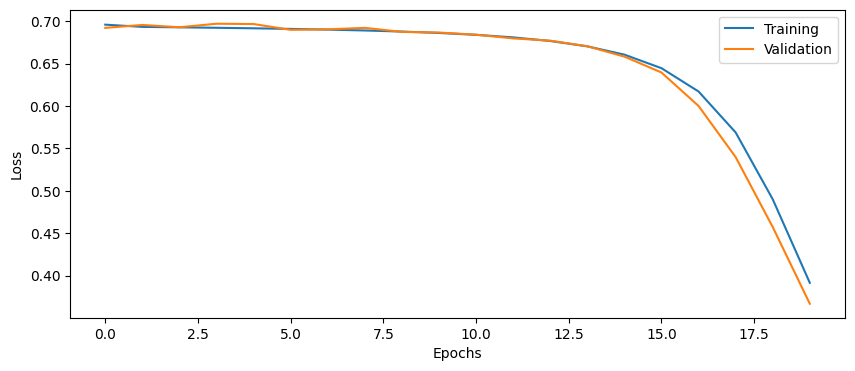

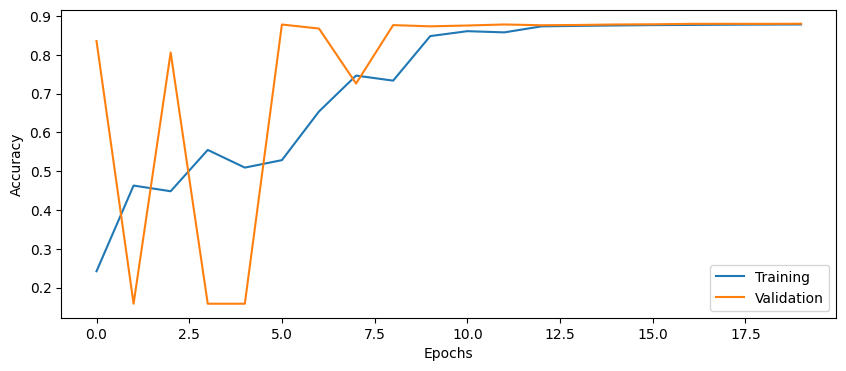

In [ ]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model4 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=50, learning_rate=0.1)

history4 = model4.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 11ms/step - loss: 0.5986 - accuracy: 0.8231 - val_loss: 0.4905 - val_accuracy: 0.8876
Epoch 2/20
54/54 [==============================] - 0s 7ms/step - loss: 0.3839 - accuracy: 0.8855 - val_loss: 0.3243 - val_accuracy: 0.8864
Epoch 3/20
54/54 [==============================] - 1s 11ms/step - loss: 0.2675 - accuracy: 0.8856 - val_loss: 0.2773 - val_accuracy: 0.8891
Epoch 4/20
54/54 [==============================] - 1s 9ms/step - loss: 0.2329 - accuracy: 0.8884 - val_loss: 0.2657 - val_accuracy: 0.8912
Epoch 5/20
54/54 [==============================] - 0s 9ms/step - loss: 0.2198 - accuracy: 0.8908 - val_loss: 0.2582 - val_accuracy: 0.8934
Epoch 6/20
54/54 [==============================] - 1s 9ms/step - loss: 0.2126 - accuracy: 0.8926 - val_loss: 0.2528 - val_accuracy: 0.8949
Epoch 7/20
54/54 [==============================] - 0s 9ms/step - loss: 0.2077 - accuracy: 0.8942 - val_loss: 0.2499 - val_accuracy: 0.8968
Epoch 8/20
54/54 [

In [ ]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 3ms/step - loss: 0.2305 - accuracy: 0.9043
Test loss: 0.2305
Test accuracy: 0.9043


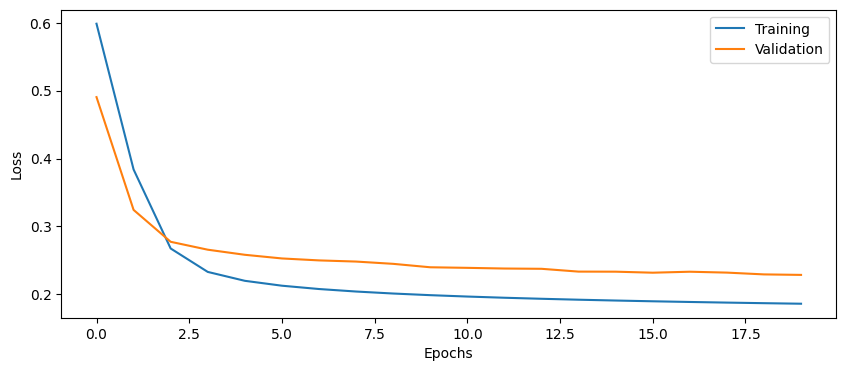

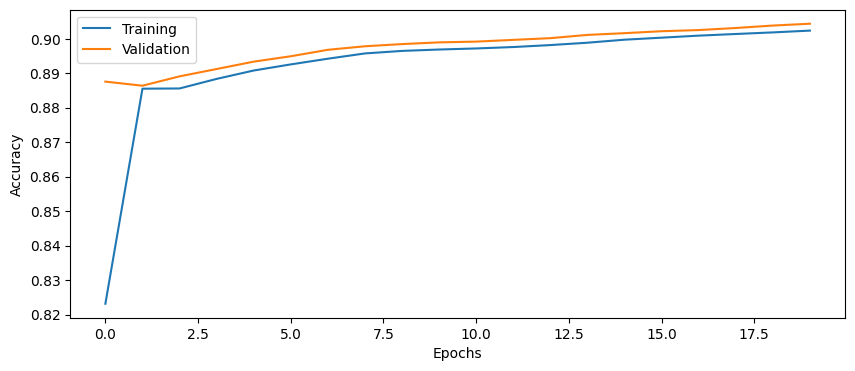

In [ ]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model5 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=50, learning_rate=0.1)

history5 = model5.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 11ms/step - loss: 0.6932 - accuracy: 0.5856 - val_loss: 0.6937 - val_accuracy: 0.1587
Epoch 2/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6922 - accuracy: 0.5750 - val_loss: 0.7012 - val_accuracy: 0.1584
Epoch 3/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6913 - accuracy: 0.5494 - val_loss: 0.6844 - val_accuracy: 0.8416
Epoch 4/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6903 - accuracy: 0.6769 - val_loss: 0.6926 - val_accuracy: 0.6589
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6892 - accuracy: 0.7585 - val_loss: 0.6908 - val_accuracy: 0.8666
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6877 - accuracy: 0.8058 - val_loss: 0.6873 - val_accuracy: 0.8834
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.6858 - accuracy: 0.8180 - val_loss: 0.6821 - val_accuracy: 0.8957
Epoch 8/20
54/54 [=

In [ ]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 50)                4650      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 50)                2550      
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 12351 (48.25 KB)
Trainable params: 12351 (48.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 4ms/step - loss: 0.2543 - accuracy: 0.8897
Test loss: 0.2543
Test accuracy: 0.8897


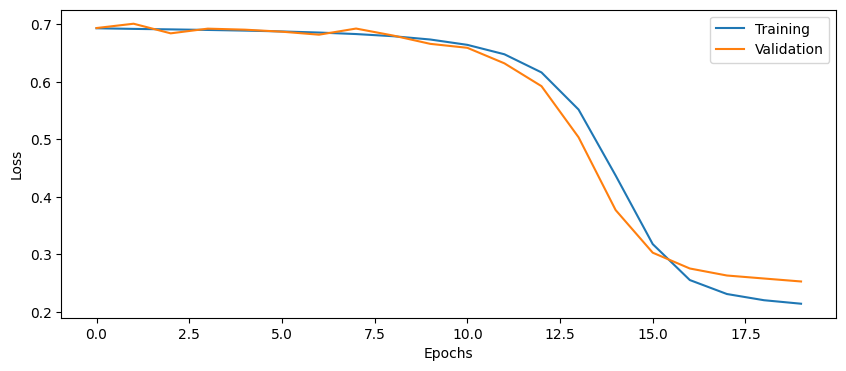

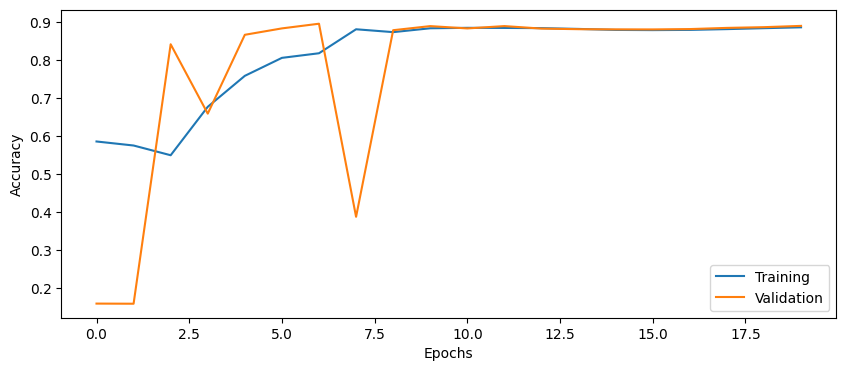

In [ ]:
plot_results(history5)

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers.

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

It helps improve the speed, performance and stability of deep neural networks. Normalizing the input makes optimization easier, since the loss function behaves nicer. So doing normalization at the output in each layer would be better.

### 2 layers, 20 nodes, class weights, batch normalization

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model6 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, use_bn=True)

history6 = model6.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 3s 13ms/step - loss: 0.2936 - accuracy: 0.8617 - val_loss: 0.3816 - val_accuracy: 0.8416
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.2127 - accuracy: 0.9010 - val_loss: 0.3557 - val_accuracy: 0.8416
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1962 - accuracy: 0.9070 - val_loss: 0.3082 - val_accuracy: 0.8416
Epoch 4/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1883 - accuracy: 0.9092 - val_loss: 0.2517 - val_accuracy: 0.8416
Epoch 5/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1833 - accuracy: 0.9107 - val_loss: 0.2056 - val_accuracy: 0.8636
Epoch 6/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1798 - accuracy: 0.9117 - val_loss: 0.1805 - val_accuracy: 0.9085
Epoch 7/20
54/54 [==============================] - 0s 8ms/step - loss: 0.1771 - accuracy: 0.9132 - val_loss: 0.1766 - val_accuracy: 0.9170
Epoch 8/20
54/54 [=

In [ ]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 5ms/step - loss: 0.2103 - accuracy: 0.9174
Test loss: 0.2103
Test accuracy: 0.9174


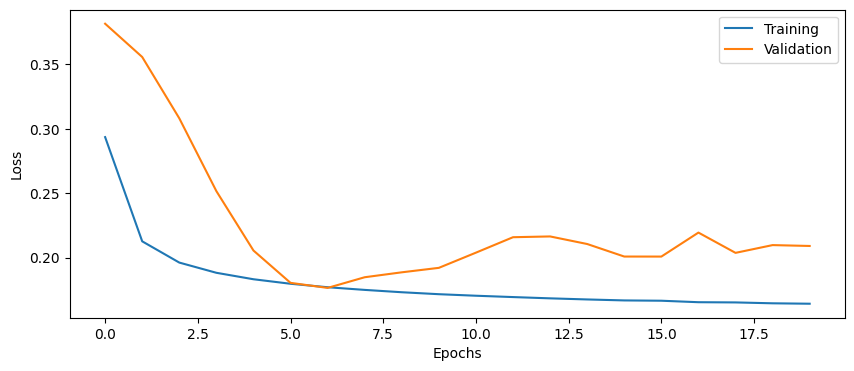

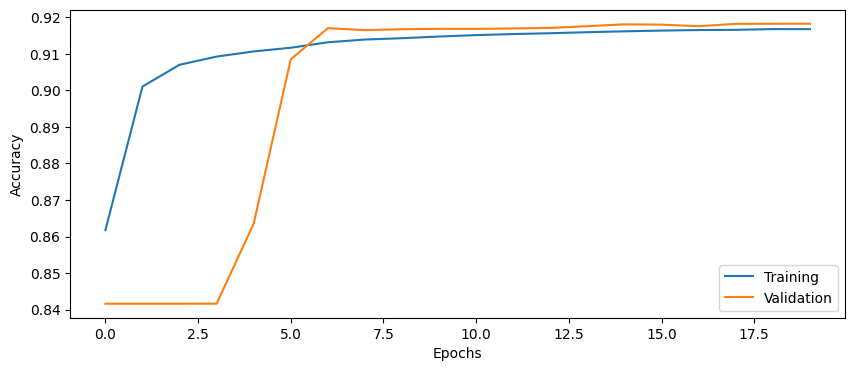

In [ ]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model7 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, act_fun='ReLU' )

history7 = model7.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 1s 10ms/step - loss: 0.3294 - accuracy: 0.8382 - val_loss: 0.2796 - val_accuracy: 0.8883
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2085 - accuracy: 0.8912 - val_loss: 0.2516 - val_accuracy: 0.8968
Epoch 3/20
54/54 [==============================] - 1s 9ms/step - loss: 0.1947 - accuracy: 0.8982 - val_loss: 0.2418 - val_accuracy: 0.9019
Epoch 4/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1885 - accuracy: 0.9024 - val_loss: 0.2348 - val_accuracy: 0.9059
Epoch 5/20
54/54 [==============================] - 1s 10ms/step - loss: 0.1842 - accuracy: 0.9057 - val_loss: 0.2237 - val_accuracy: 0.9095
Epoch 6/20
54/54 [==============================] - 1s 9ms/step - loss: 0.1813 - accuracy: 0.9077 - val_loss: 0.2254 - val_accuracy: 0.9103
Epoch 7/20
54/54 [==============================] - 1s 9ms/step - loss: 0.1789 - accuracy: 0.9089 - val_loss: 0.2246 - val_accuracy: 0.9112
Epoch 8/20
54/54 

In [ ]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 3ms/step - loss: 0.2120 - accuracy: 0.9170
Test loss: 0.2120
Test accuracy: 0.9170


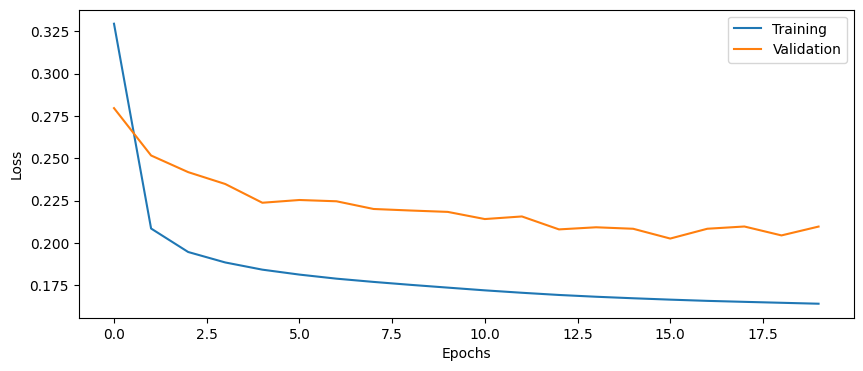

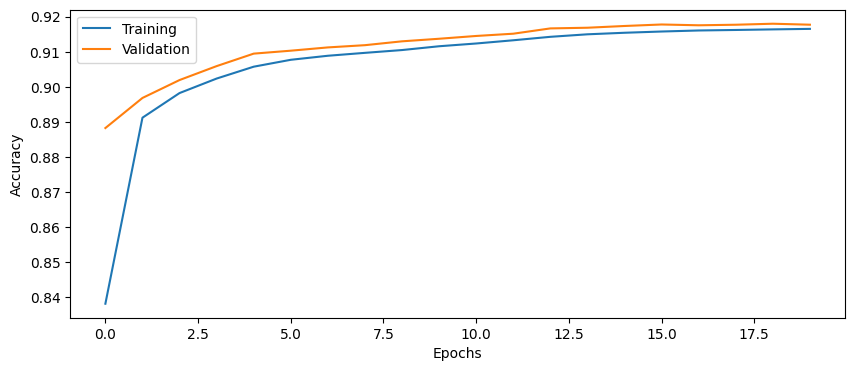

In [ ]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers.

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model8 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, optimizer='adam')

history8 = model8.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 10ms/step - loss: 0.2163 - accuracy: 0.8823 - val_loss: 0.2100 - val_accuracy: 0.9154
Epoch 2/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1660 - accuracy: 0.9161 - val_loss: 0.2110 - val_accuracy: 0.9199
Epoch 3/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1613 - accuracy: 0.9186 - val_loss: 0.2078 - val_accuracy: 0.9200
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1584 - accuracy: 0.9192 - val_loss: 0.1701 - val_accuracy: 0.9214
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1571 - accuracy: 0.9198 - val_loss: 0.1893 - val_accuracy: 0.9220
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.1532 - accuracy: 0.9202 - val_loss: 0.1865 - val_accuracy: 0.9214
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 0.1507 - accuracy: 0.9200 - val_loss: 0.2008 - val_accuracy: 0.9204
Epoch 8/20
54/54 [=

In [ ]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 3ms/step - loss: 0.1644 - accuracy: 0.9332
Test loss: 0.1644
Test accuracy: 0.9332


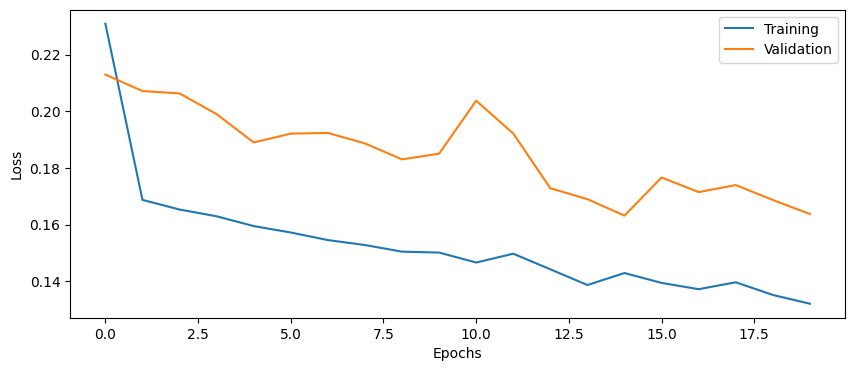

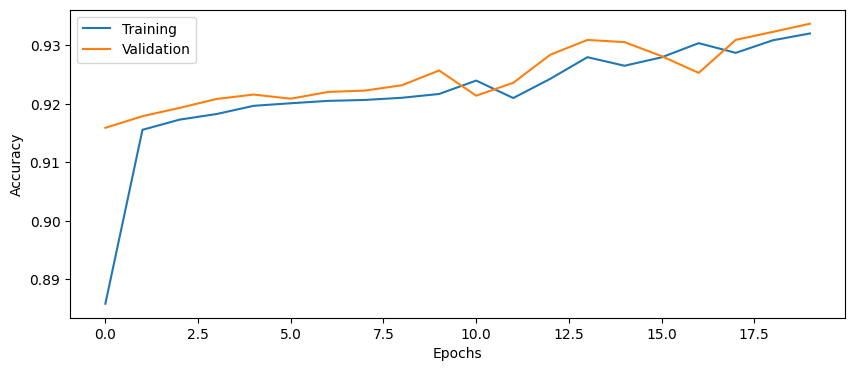

In [ ]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

> Without dropout: val_accuracy: 0.9019

> With dropout: val_accuracy: 0.8834

The validation accuracy slightly drops when using dropout layers.

Question 16: How does the test accuracy change when adding dropout?

> Without dropout: Test accuracy: 0.9016

> With dropout: Test accuracy: 0.8829

The test accuracy also slightly drops when using dropout layers. This is a bit counterintuitive as dropouts should reduce generalization errors, but it could be due to a high dropout rate which remove complexity from the model.

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model9 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, use_dropout=True)

history9 = model9.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 2s 11ms/step - loss: 0.7154 - accuracy: 0.5433 - val_loss: 0.6255 - val_accuracy: 0.8772
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.6398 - accuracy: 0.6277 - val_loss: 0.5491 - val_accuracy: 0.8816
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 0.5696 - accuracy: 0.7056 - val_loss: 0.4554 - val_accuracy: 0.8819
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.4956 - accuracy: 0.7620 - val_loss: 0.3711 - val_accuracy: 0.8816
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.4342 - accuracy: 0.7992 - val_loss: 0.3188 - val_accuracy: 0.8814
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.3922 - accuracy: 0.8231 - val_loss: 0.2914 - val_accuracy: 0.8814
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 0.3651 - accuracy: 0.8372 - val_loss: 0.2807 - val_accuracy: 0.8813
Epoch 8/20
54/54 [=

In [ ]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

12/12 [==============================] - 0s 3ms/step - loss: 0.2626 - accuracy: 0.8829
Test loss: 0.2626
Test accuracy: 0.8829


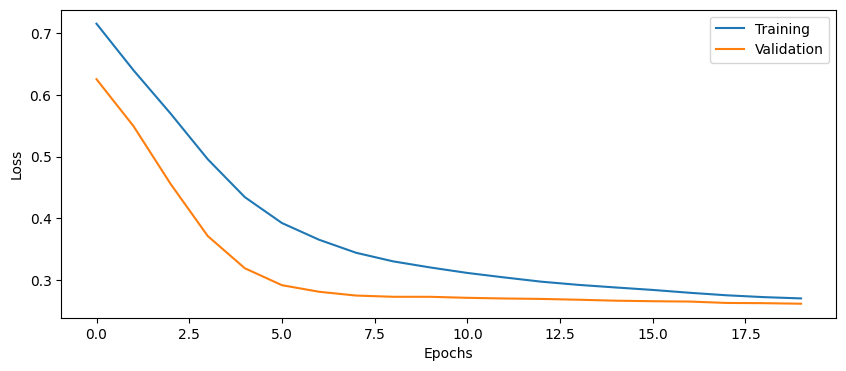

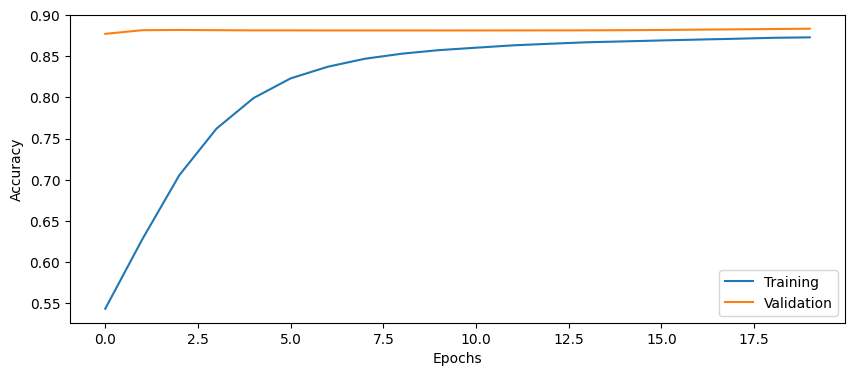

In [ ]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

> We can achieve an accuray of 0.9324 on the test data. We obtain this results by choosing the Adam optimizer with a batch size of 15000, learning rate of 0.1, 2 layers of 20 nodes, 20 epochs, no Batch normalization nor dropout layers were used.

In [ ]:
# Find your best configuration for the DNN
batch_size = 15000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train DNN
model10 = build_DNN(input_shape=input_shape,
                    n_layers=2,
                    n_nodes=20,
                    learning_rate=0.1,
                    use_bn=False,
                    optimizer='adam',
                    use_dropout=False,)

history10 = model10.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, class_weight=class_weights)


Epoch 1/20
36/36 [==============================] - 2s 16ms/step - loss: 0.2701 - accuracy: 0.8717 - val_loss: 0.2219 - val_accuracy: 0.9135
Epoch 2/20
36/36 [==============================] - 0s 9ms/step - loss: 0.1742 - accuracy: 0.9123 - val_loss: 0.2122 - val_accuracy: 0.9157
Epoch 3/20
36/36 [==============================] - 0s 10ms/step - loss: 0.1687 - accuracy: 0.9154 - val_loss: 0.2106 - val_accuracy: 0.9174
Epoch 4/20
36/36 [==============================] - 1s 14ms/step - loss: 0.1660 - accuracy: 0.9165 - val_loss: 0.2062 - val_accuracy: 0.9183
Epoch 5/20
36/36 [==============================] - 0s 13ms/step - loss: 0.1638 - accuracy: 0.9170 - val_loss: 0.2078 - val_accuracy: 0.9187
Epoch 6/20
36/36 [==============================] - 0s 13ms/step - loss: 0.1620 - accuracy: 0.9179 - val_loss: 0.2023 - val_accuracy: 0.9201
Epoch 7/20
36/36 [==============================] - 0s 12ms/step - loss: 0.1591 - accuracy: 0.9192 - val_loss: 0.1959 - val_accuracy: 0.9212
Epoch 8/20
36/

In [ ]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

8/8 [==============================] - 0s 4ms/step - loss: 0.1640 - accuracy: 0.9324
Test loss: 0.1640
Test accuracy: 0.9324


# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on.

Question 18: What is the mean and the standard deviation of the test accuracy?

> The mean is 0.9144353991746903 and the standard deviation is 0.00014872807714425842

In [ ]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training


    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training:
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [ ]:
# Your best training parameters

batch_size = 15000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model11 = build_DNN(input_shape=input_shape,
                    n_layers=2,
                    n_nodes=20,
                    learning_rate=0.1,
                    use_bn=False,
                    optimizer='adam',
                    use_custom_dropout=True)


history11 = model11.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=epochs, batch_size=batch_size, class_weight=class_weights)

Epoch 1/20
36/36 [==============================] - 2s 15ms/step - loss: 0.2863 - accuracy: 0.8682 - val_loss: 0.2442 - val_accuracy: 0.8987
Epoch 2/20
36/36 [==============================] - 0s 8ms/step - loss: 0.1978 - accuracy: 0.9028 - val_loss: 0.2276 - val_accuracy: 0.9084
Epoch 3/20
36/36 [==============================] - 0s 9ms/step - loss: 0.1860 - accuracy: 0.9084 - val_loss: 0.2190 - val_accuracy: 0.9114
Epoch 4/20
36/36 [==============================] - 0s 9ms/step - loss: 0.1805 - accuracy: 0.9110 - val_loss: 0.2199 - val_accuracy: 0.9129
Epoch 5/20
36/36 [==============================] - 0s 8ms/step - loss: 0.1782 - accuracy: 0.9119 - val_loss: 0.2210 - val_accuracy: 0.9133
Epoch 6/20
36/36 [==============================] - 0s 8ms/step - loss: 0.1771 - accuracy: 0.9125 - val_loss: 0.2211 - val_accuracy: 0.9139
Epoch 7/20
36/36 [==============================] - 0s 9ms/step - loss: 0.1769 - accuracy: 0.9124 - val_loss: 0.2171 - val_accuracy: 0.9134
Epoch 8/20
36/36 [=

In [ ]:
# Run this cell a few times to evalute the model on test data,
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test accuracy: %.4f' % score[1])

8/8 [==============================] - 0s 5ms/step - loss: 0.2197 - accuracy: 0.9144
Test accuracy: 0.9144


In [ ]:
# Run the testing 100 times, and save the accuracies in an array

accs = [0]*100
for i in range(100):
    score_i = model11.evaluate(Xtest, Ytest, batch_size=batch_size)
    accs[i] = score_i[1]
# Calculate and print mean and std of accuracies
mean_acc = np.mean(accs)
std_acc = np.std(accs)
print(f"Mean of accuracies is {mean_acc}")
print(f"The standard deviation of the accuracies is {std_acc}")


8/8 [==============================] - 0s 6ms/step - loss: 0.2196 - accuracy: 0.9146
Mean of accuracies is 0.9144353991746903
The standard deviation of the accuracies is 0.00014872807714425842


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234.

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

> The mean is 0.921913081407547 and the standard deviation is 0.003319092612871593

Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

> Dropout provides a better way to intergate uncertanity into our model without having to increase the computation needs to do so. CV would require more computation to have this uncertainity into the model


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation
cv= StratifiedKFold(n_splits=10, random_state=None, shuffle=True)

# Loop over cross validation folds
acc = []

for train_index, test_index in cv.split(Xcopy, Ycopy):
   x_train_fold, x_test_fold = Xcopy[train_index], Xcopy[test_index]
   y_train_fold, y_test_fold = Ycopy[train_index], Ycopy[test_index]
   # Calculate class weights for current split

   class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_fold), y = y_train_fold )

   class_weights = {0: class_weights[0],1: class_weights[1]}

   # Rebuild the DNN model, to not continue training on the previously trained model
   model12 = build_DNN(input_shape,2,20,learning_rate = 0.1, optimizer = "adam")

   # Fit the model with training set and class weights for this fold
   history12 = model12.fit(x_train_fold,y_train_fold,batch_size=batch_size, epochs=epochs, class_weight = class_weights)

   # Evaluate the model using the test set for this fold
   score = model12.evaluate(Xtest,Ytest,batch_size = batch_size)

   # Save the test accuracy in an array
   acc.append(score[1])

Epoch 1/20
46/46 [==============================] - 2s 10ms/step - loss: 0.2393 - accuracy: 0.8832
Epoch 2/20
46/46 [==============================] - 0s 10ms/step - loss: 0.1692 - accuracy: 0.9153
Epoch 3/20
46/46 [==============================] - 0s 10ms/step - loss: 0.1640 - accuracy: 0.9175
Epoch 4/20
46/46 [==============================] - 0s 10ms/step - loss: 0.1598 - accuracy: 0.9196
Epoch 5/20
46/46 [==============================] - 0s 9ms/step - loss: 0.1572 - accuracy: 0.9207
Epoch 6/20
46/46 [==============================] - 0s 6ms/step - loss: 0.1544 - accuracy: 0.9210
Epoch 7/20
46/46 [==============================] - 0s 6ms/step - loss: 0.1521 - accuracy: 0.9209
Epoch 8/20
46/46 [==============================] - 0s 6ms/step - loss: 0.1515 - accuracy: 0.9211
Epoch 9/20
46/46 [==============================] - 0s 6ms/step - loss: 0.1474 - accuracy: 0.9214
Epoch 10/20
46/46 [==============================] - 0s 7ms/step - loss: 0.1480 - accuracy: 0.9210
Epoch 11/20
46/

In [ ]:
# Calculate and print mean and std of accuracies
print("mean: {}.".format(np.mean(acc)))
print("std: {}.".format(np.std(acc)))

mean: 0.921913081407547.
std: 0.003319092612871593.


# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

> For regression, we would need to change the activation function in the finallayer, the metric used and the loss function that we use.

## Report

Send in this jupyter notebook, with answers to all questions.